# Using Markov transition matrices to generate trial configurations in Markov chain Monte Carlo simulations - 2D Model

## Table of Contents
1. [Routines and dependencies](#Functions)
2. [Main - Generation of the sampling](#Algorithms) <br />
    2.1 [Generate the sampling](#GenSamp)  <br />
    2.2 [Prior and Target distribution - Analytical](#Prior&target)<br />
3. [Figures](#Figures)<br />
    3.1 [Figure 3(a) - Target distribution - Sampling](#TargetSampling)<br />
    3.2 [Figure 3(b)](#Fig1B)<br />
    3.3 [Figure 5](#Fig3)<br />
    3.4 [Figure 9](#Fig.9)<br />
    3.5 [Figure 10](#Fig.SI1)<br />
4. [Asymptotic distribution](#Asymptotic)<br />
    4.1 [Generating the asymptotic distribution](#GenAsymptotic)<br />
    4.2 [Sampling of the asymptotic distribution](#SampAsymptotic)<br />
    4.3 [Comparing the asymptotic and the TMCMC](#CompASTMCMC)<br />

## 1. Routines and dependencies <a name="Functions"></a>

Import the dependencies.

In [1]:
from mpl_toolkits.mplot3d import Axes3D  
import numpy as np
import scipy as sp
import os
import errno
from pylab import show,hist,subplot,figure 
from numpy import linalg as nla
import matplotlib.pyplot as plt
from copy import copy, deepcopy
from matplotlib import pyplot
from matplotlib import gridspec
import matplotlib.font_manager as font_manager
import matplotlib.offsetbox
from matplotlib.lines import Line2D

# use latex for font rendering
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['text.usetex'] = True

Define the routines.

In [2]:
sigmax1=0.6
sigmax2=0.6


def prior_prob(x):
    """Return a float

    Compute the prior distribution \pi_0(x)
    """
    prob=np.exp(-x[0]**2/2./sigmax1**2-x[1]**2/2./sigmax2**2)/(2.*np.pi)/sigmax1/sigmax2
    return prob

    
def sample_prior(): 
    """Return a ndim-dimensional array of floats

    Generate a random variable distributed as prior_prob(x) if Gaussian
    """
    rnd1=np.random.rand(2)
    r1=np.sqrt(-2.*np.log(1-rnd1[0]))*sigmax1
    x1=np.cos(rnd1[1]*2.*np.pi)*r1
    rnd2=np.random.rand(2)
    r2=np.sqrt(-2.*np.log(1-rnd2[0]))*sigmax2
    x2=np.cos(rnd2[1]*2.*np.pi)*r2
    return np.array([[x1],[x2]])


def sample_prior_rejection(): 
    """Return a ndim-dimensional array of floats

    Generate a random variable distributed as prior_prob() using the method of rejection
    """
    x=10*(2*np.random.rand(ndim)-1)
    hmax = 1
    h = np.random.uniform(0,hmax)
    while prior_prob(x) < h:
        x=10*(2*np.random.rand(ndim)-1)
        h = np.random.uniform(0,hmax)
    return x





def Ptarg(x): 
    """Return a float

    Compute the target distribution \pi(x)
    """
    tm1 = np.array([2,2])
    sigmaTx11 = 0.5
    sigmaTx21 = 0.5
    rho1 = -0.7
    
    Ptarg = (np.exp(-(x[0]+tm1[0])**2/2./sigmaTx11**2/(1-rho1**2)-(x[1]+tm1[1])**2/2./sigmaTx21**2/(1-rho1**2)+
                   (x[0]+tm1[0])*(x[1]+tm1[1])*rho1/sigmaTx11/sigmaTx21/(1-rho1**2)))
    
    tm2 = np.array([2,1])
    sigmaTx12 = 0.6
    sigmaTx22 = 0.3
    rho2 = 0
    
    Ptarg += (np.exp(-(x[0]+tm2[0])**2/2./sigmaTx12**2/(1-rho2**2)-(x[1]+tm2[1])**2/2./sigmaTx22**2/(1-rho2**2)+
                   (x[0]+tm2[0])*(x[1]+tm2[1])*rho2/sigmaTx12/sigmaTx22/(1-rho2**2)))
    
    tm3 = np.array([-2,2])
    sigmaTx13 = 0.3
    sigmaTx23 = 0.6
    rho3 = 0.3
    
    Ptarg += (np.exp(-(x[0]+tm3[0])**2/2./sigmaTx13**2/(1-rho3**2)-(x[1]+tm3[1])**2/2./sigmaTx23**2/(1-rho3**2)+
                   (x[0]+tm3[0])*(x[1]+tm3[1])*rho3/sigmaTx13/sigmaTx23/(1-rho3**2)))
    
    return Ptarg


def acc(x,y):
    """Return two floats

    Compute the acceptance acc(x->y) using Metropolis or Heat-bath method
    Return 1) Jxx = 1-acc(x->y), 2) Jxx = acc(x->y)
    """
    Pnew=Ptarg(y)
    Pold=Ptarg(x)
    # Metropolis
#    if(Pnew>Pold):
#        Jxy=1.
#    else:
#        Jxy=Pnew/Pold    
    # Heat-bath
    Jxy=Pnew/(Pnew+Pold)
    Jxx=1.-Jxy  
    return Jxx, Jxy



def f(x,y,px,py,Dx):
    """Return three floats and one integer

    Configuration at layer i+1: y (=x+Dx)
    Configurations at layer i: y and x (prior prababilities py and px)
    The function samples between y and x at layer i
    Return: 1) the probability of y at layer i+1, 
            2) Jxy = acc(x->y),
            3) Jyy = 1-acc(y->y+Dx),
            4) new = 1 (0) if at layer i x (y) is selected
    """
    Jxx, Jxy = acc(x,y)
    z=np.zeros((ndim,1))
    for i in range(ndim):
        z[i]=y[i]+Dx[i]
    Jyy, Jyydx =acc(y,z)
    newpy=px*Jxy+py*Jyy
    rnd=np.random.rand(1)
    if(rnd[0]<px*Jxy/newpy):
        new=1
    else:
        new=0
    return newpy, Jxy,Jyy, new

def generate_y(n,dxVec): 
    """Return an array of ndim floats, one float and an array of n integers

    The function generates a trial optimized configuration y 
    Return: 1) The trial configuration y = y0 + VecEta_i * dxVec_i
            2) The generating probability  P_gen(y) = \pi_0(y_0)*\prod_{i=0}^{n-1}f(y_{i}->y_{i+1})
            3) The list of accepted/rejected moves {\eta}: 
                \eta_i = 1 (0) if the move y_{i} -> y_{i}+dxVec_i is accepted (rejected)
    """
    # The list of accepted/rejected moves {\eta}
    VecEta=np.array([]) 
    
    
    # Generates the initial state (x=y0) in the first layer 
    x=sample_prior()

    # Initialise the probability of the trajectory
    prob=prior_prob(x)

    ilayer=0
    while(ilayer<n):
        y=np.zeros((ndim,1))
        for i in range(ndim):
            y[i]=x[i]+dxVec[i,ilayer]
        
        # Compute the acceptance
        accxx, accxy = acc(x,y)

        rnd=np.random.rand(1)
        if(rnd[0]<accxy):
            x=deepcopy(y)
            prob=prob*accxy             
            VecEta=np.append(VecEta,1)
            
        else:
            prob=prob*accxx    
            VecEta=np.append(VecEta,0)
            
        ilayer=ilayer+1
    
    
    return x, prob, VecEta

def regenerate_B(xn,n,dxVec):     
    """Return a float

    Return the tree (or full) probability of xn or yn as used in Algorithm B 
    and P_gen(x_{0,n}|K) or P_gen(y_{0,n}|K)
    """
    # n2n is the number of trajectories ending in yn
    n2n=np.power(2,n)
    
    x0Vec=np.ones((ndim,n2n))
    for i in range(ndim):
        for j in range(n2n):
            x0Vec[i,j]=xn[i]
            

    # Initalisation of x0Vec, the array of the 2^n states in the first layer that connected to x^n 
    # with a combination of dxVec and eta's
    ix0=0
    while(ix0<n2n):
        acn=n2n+ix0
        ibit=1
        while(ibit<n+1):
            acb=extractKBits(acn,1,ibit)
            
            for i in range(ndim):
                x0Vec[i,ix0]=x0Vec[i,ix0]-acb*dxVec[i,ibit-1]
            ibit=ibit+1

        ix0=ix0+1
        
    # Running posteriori probabilities 
    piVec=np.zeros(n2n) 
    fluxVec=np.zeros(n2n)

    # initialisation
    ix0=0
    while(ix0<n2n):
        piVec[ix0]=prior_prob(x0Vec[:,ix0])
        ix0=ix0+1

    ilayer=0
    while(ilayer<n):
        dnx=np.power(2,ilayer)
        dny=np.power(2,ilayer+1)
        ix0=0

        while(ix0<n2n):
            y=x0Vec[:,ix0]
            x=x0Vec[:,ix0+dnx]
            py=piVec[ix0]
            px=piVec[ix0+dnx]

            newpy, Jxy, Jyy, new = f(x,y,px,py,dxVec[:,ilayer])
            piVec[ix0]=newpy
            
            if(new==1):
                fluxVec[ix0]=fluxVec[ix0+dnx]*Jxy 
            else:
                fluxVec[ix0]=fluxVec[ix0]*Jyy           

            ix0=ix0+dny
     
        ilayer=ilayer+1
   
    return piVec[0], fluxVec[0]


def regenerate_A(xn,n,dxVec,VecEta):     
    """Return a float

    Return the probability of the trajectory {dxVec, VecEta} ending in xn as used in Algorithm A
    """
    
    # Obtain the n+1 states of the trajectory (dxVec, eta) ending in n 
    Vec_x0=np.zeros((ndim,n+1))
    for i in range(ndim):
        Vec_x0[i,n]=xn[i]
    ip=n-1
    while(ip>=0):
        for i in range(ndim):
            Vec_x0[i,ip]=Vec_x0[i,ip+1]-VecEta[ip]*dxVec[i,ip]
        ip=ip-1
        
        
    # Compute the probability of the trajectory 
    prob=prior_prob(Vec_x0[:,0])
    
    ip=0
    while(ip<n):
        x=Vec_x0[:,ip]
        y=Vec_x0[:,ip]+dxVec[:,ip]
        Jyy, Jxy = acc(x,y)
        if(VecEta[ip] == 1):
            prob=prob*Jxy
        else:
            prob=prob*Jyy        
        ip=ip+1

    return prob

def generate_y_prime(n,dxVec,VecEta): 
    """Return an array of ndim floats, one float and an array of n integers

    The function generates a trial configuration y given a set of displacement dxVec and of {eta}
    as used in Algorithms prime
    Return: 1) The trial configuration y = y0 + VecEta_i * dxVec_i
            2) The generating probability  P_gen(y) = \pi_0(y_0)*\prod_{i=0}^{n-1}f(y_{i}->y_{i+1})

    """
    # Initialize the set of states in the Markov Chain
    Vec_y0=np.zeros((ndim,n+1))
    # The initial layer is generated from the prior distribution \pi_0
    y=sample_prior()
    for i in range(ndim):
        Vec_y0[i,0]=y[i]

    ip=0
    while(ip<n):
        for i in range(ndim):
            Vec_y0[i,ip+1]=Vec_y0[i,ip]+VecEta[ip]*dxVec[i,ip]
        ip+=1
        
    prob=prior_prob(Vec_y0[:,0])

    return Vec_y0[:,-1], prob


def regenerate_Aprime(yn,n,dxVec,VecEta): 
    """Return a float

    Return the probability of the trajectory {dxVec, VecEta} ending in xn as defined in Algorithm A prime
    """ 
    Vec_x0=np.zeros((ndim,n+1))

    for i in range(ndim):
        Vec_x0[i,n]=yn[i]
    ip=n-1
    while(ip>=0):
        for i in range(ndim):
            Vec_x0[i,ip]=Vec_x0[i,ip+1]-VecEta[ip]*dxVec[i,ip]
        ip=ip-1
    
    prob=prior_prob(Vec_x0[:,0])
    
    return prob

def regenerate_Bprime(xn,n,dxVec): 
    """Return a float

    The function computes the tree probability of yn or xn as used in Algorithm B prime
    """
    # n2n is the number of trajectories ending in yn
    n2n=np.power(2,n)
    
    x0Vec=np.ones((ndim,n2n))
    for i in range(ndim):
        for j in range(n2n):
            x0Vec[i,j]=xn[i]
            
    # Initalisation of x0Vec, the array of the 2^n states in the first layer that connected to x^n 
    # with a combination of dxVec and eta's
    ix0=0
    while(ix0<n2n):
        acn=n2n+ix0
        ibit=1
        while(ibit<n+1):
            acb=extractKBits(acn,1,ibit)
            
            for i in range(ndim):
                x0Vec[i,ix0]=x0Vec[i,ix0]-acb*dxVec[i,ibit-1]
            ibit=ibit+1

        ix0=ix0+1
            
        
    # Running posteriori probabilities 
    piVec=np.zeros(n2n) 

    # initialisation
    ix0=0
    while(ix0<n2n):
        piVec[ix0]=prior_prob(x0Vec[:,ix0])
        ix0=ix0+1
   
    return piVec.sum()



def generate_dxVec(n,dxVec,dxMax):
    """Return a (ndim,n)-dim array of floats

    The function generates the n displacements
    """
    dimlayer=0
    while(dimlayer<ndim):
        dxVec[dimlayer]=dxMax*(2*np.random.rand(n)-1.)
        dimlayer=dimlayer+1
    return dxVec


def extractKBits(num,k,p):
    """Return an integer

    Extract ‘k’ bits at a given position 'p' of the binary representation of 'num'
    adapted from https://www.geeksforgeeks.org/python-slicing-extract-k-bits-given-position/
    """

    # convert number into binary first 
    binary = bin(num) 

    # remove first two characters 
    binary = binary[2:] 

    end = len(binary) - p 
    start = end - k + 1

    # extract k  bit sub-string 
    kBitSubStr = binary[start : end+1] 

    # convert extracted sub-string into decimal again 
    return int(kBitSubStr,2)

class AnchoredHScaleBar(matplotlib.offsetbox.AnchoredOffsetbox):
    """ size: length of bar in data units
        extent : height of bar ends in axes units
        adapted from https://stackoverflow.com/questions/43258638/is-there-a-convenient-way-to-add-a-scale-indicator-to-a-plot-in-matplotlib
        """
    def __init__(self, size=1, extent = 0.03, label=None, loc=2, ax=None,
                 pad=0.4, borderpad=0.5, ppad = 0, sep=2, prop=None, 
                 frameon=True, linekw={}, **kwargs):
        if not ax:
            ax = plt.gca()
        trans = ax.get_xaxis_transform()
        size_bar = matplotlib.offsetbox.AuxTransformBox(trans)
        line = Line2D([0,size],[0,0], **linekw)
        vline1 = Line2D([0,0],[-extent/2.,extent/2.], **linekw)
        vline2 = Line2D([size,size],[-extent/2.,extent/2.], **linekw)
        size_bar.add_artist(line)
        size_bar.add_artist(vline1)
        size_bar.add_artist(vline2)
        self.vpac = matplotlib.offsetbox.VPacker(children=[size_bar],  
                                 align="center", pad=ppad, sep=sep) 
        matplotlib.offsetbox.AnchoredOffsetbox.__init__(self, loc, pad=pad, 
                 borderpad=borderpad, child=self.vpac, prop=prop, frameon=frameon,
                 **kwargs)

## 2. Main <a name="Algorithms"></a>

### 2.1 Generate the sampling <a name="GenSamp"></a>

In [6]:
# Parameters of the model
ndim=2
n=4 # Number of iterations in the truncated Markov Chain (number of layers = n+1)
NMC=1000000 # Total number if Monte Carlo iterations
dxMax=2#/np.sqrt(n)  # Maximal diplacement

# Choice of algorithm
AlgoA = 1
AlgoB = 0
AlgoAPrime = 0
AlgoBPrime = 0

# Define the variables
dxVec=np.zeros((ndim,n)) # Vector with the displacements
accrate=0 # Rate of accepted trial states
iMC=0 # Number of iterations

# Sampling
xVec=np.zeros((ndim,NMC)) 
yVec = np.zeros((ndim,NMC)) # Sampling of the trial configuration generated with the truncated Markov chain
zstats = np.zeros((5,NMC)) # Statistics of z

# Generate the first state
dxVec=generate_dxVec(n,dxVec,dxMax)

if AlgoA==1 or AlgoB==1:
    x, prob, VecEta = generate_y(n,dxVec)

if AlgoAPrime==1 or AlgoBPrime==1:
    VecEta = np.random.randint(0,2,n)
    x, prob = generate_y_prime(n,dxVec,VecEta)



print('starting x=', x, 'starting prob=', prob,'dxVec=', dxVec,'VecEta =',VecEta )


while(iMC<NMC):    
        
    # Generate a new displacement
    dxVec = generate_dxVec(n,dxVec,dxMax)
    
    # Algorithm A
    if AlgoA == 1:
        # Generate y and compute Pgen(y)
        y, probtrajnew, VecEtanew = generate_y(n,dxVec)
        # Generate a random set for eta^A
        VecEtaA = np.random.randint(0,2,n)
        # Compute the prob along the eta^A
        probtrajold = regenerate_A(x,n,dxVec,VecEtaA)
        
        probold = probtrajold 
        probnew = probtrajnew
        
        name = '2D_AlgoA_NMC=%g_dxMax=%g_n=%g' % (NMC,dxMax,n)
        for i in range(ndim):
            yVec[i,iMC]=y[i]
     
    # Algorithm B
    if AlgoB == 1:
        # Generate ynew and compute Pgen(ynew)
        y, probtrajnew, VecEtanew = generate_y(n,dxVec)
        # Compute the probability of the tree leading to ynew
        probtreenew, probtrajnew = regenerate_B(y,n,dxVec)
        # Compute the probability of the tree leading to yold
        probtreeold, probtrajold = regenerate_B(x,n,dxVec)
        
        probold = probtreeold 
        probnew = probtreenew
        
        name = '2D_AlgoB_NMC=%g_dxMax=%g_n=%g' % (NMC,dxMax,n)
        for i in range(ndim):
            yVec[i,iMC]=y[i]
     
    # Algorithm A'
    if AlgoAPrime == 1:
        # Generate a random set for eta_new
        VecEtanew = np.random.randint(0,2,n)
        # Generate ynew and compute Pgennew
        y, pgennew = generate_y_prime(n,dxVec,VecEtanew)
        # Generate a random set for eta_old
        VecEtaA = np.random.randint(0,2,n)
        # Compute the prob along the eta_old
        pgenold  = regenerate_Aprime(x,n,dxVec,VecEtaA)
        
        probold = pgenold
        probnew = pgennew
        
        name = '2D_AlgoAPrime_NMC=%g_dxMax=%g_n=%g' % (NMC,dxMax,n)
        for i in range(ndim):
            yVec[i,iMC]=y[i]
     
    # Algorithm B'
    if AlgoBPrime == 1:
        # Generate a random set for eta_new
        VecEtanew = np.random.randint(0,2,n)
        # Generate ynew 
        y, pgennew = generate_y_prime(n,dxVec,VecEtanew)
        # Compute P_Tree
        probtreenew = regenerate_Bprime(y,n,dxVec)    
        probtreeold = regenerate_Bprime(x,n,dxVec)
    
        probold = probtreeold 
        probnew = probtreenew
        
        name = '2D_AlgoBPrime_NMC=%g_dxMax=%g_n=%g' % (NMC,dxMax,n)
        for i in range(ndim):
            yVec[i,iMC]=y[i]
        

    Pnew=Ptarg(y)
    Pold=Ptarg(x)
    

    #Metropolis
    testacc = Pnew/Pold* probold/probnew # * Jxnold / Jxnnew

   
    #Heat-Bath
#    testacc = Pnew*probold/(Pold*probnew + Pnew*probold)


    rnd = np.random.rand(1)
    if(rnd[0]<testacc):
        x=deepcopy(y)
        accrate=accrate+1

    # Save the sampling
    for i in range(ndim):
        xVec[i,iMC]=x[i]

    # Statistic of z (testacc)
    zstats[0,iMC] = probold 
    zstats[1,iMC] = probnew
    zstats[2,iMC] = Pold
    zstats[3,iMC] = Pnew
    zstats[4,iMC] = probtrajold




    if(np.mod(iMC*10,NMC)==0):
        print('Number of iterations: ',iMC, 'Acceptance rate:',accrate/(iMC+1))

    iMC=iMC+1


print('Final acceptance rate:',accrate/NMC)


starting x= [1.03476224 0.84091298] starting prob= 0.020052655936301168 dxVec= [[ 1.34773528 -0.23058134  1.36729666 -0.32580526]
 [ 0.48488153  1.07580749 -1.07401397  1.54271907]] VecEta = [1 1 1 0]
Number of iterations:  0 Acceptance rate: 1.0
Number of iterations:  10 Acceptance rate: 0.2727272727272727
Number of iterations:  20 Acceptance rate: 0.23809523809523808
Number of iterations:  30 Acceptance rate: 0.1935483870967742
Number of iterations:  40 Acceptance rate: 0.17073170731707318
Number of iterations:  50 Acceptance rate: 0.1568627450980392
Number of iterations:  60 Acceptance rate: 0.13114754098360656
Number of iterations:  70 Acceptance rate: 0.11267605633802817
Number of iterations:  80 Acceptance rate: 0.09876543209876543
Number of iterations:  90 Acceptance rate: 0.08791208791208792
Final acceptance rate: 0.08


In [10]:
# Save the sampling
path = os.getcwd()
try:
    os.makedirs(path+'/data/')
    os.makedirs(path+'/plots/')
except OSError as exc: # Python >2.5
    if exc.errno == errno.EEXIST and os.path.isdir(path):
        pass
    else: raise

np.save('data/'+name+'_xVec', xVec)
np.save('data/'+name+'_yVec', yVec)
np.save('data/'+name+'_zstats', zstats)

### 2.2 Prior and target distributions - analytical <a name="Prior&target"></a>

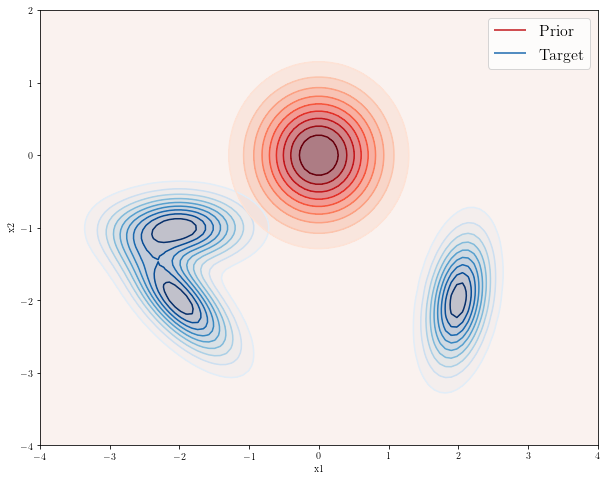

In [7]:
xlist = np.linspace(-4.0, 4.0, 100)
ylist = np.linspace(-4, 2, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = prior_prob(np.array([X, Y]))
ZT = Ptarg(np.array([X, Y]))



fig,ax=plt.subplots(1,1,figsize=(10, 8))
cpt = ax.contourf(X, Y, ZT/np.nanmax(ZT),10,alpha=.5,cmap='Blues',extend='max')
cp = ax.contourf(X, Y, Z/np.nanmax(Z),10,alpha=.5,cmap='Reds',extend='max')
cptc = ax.contour(X, Y, ZT/np.nanmax(ZT),10,alpha=1,cmap='Blues',extend='max')
cpc = ax.contour(X, Y, Z/np.nanmax(Z),10,alpha=1,cmap='Reds',extend='max')


ax.set_xlabel('x1')
ax.set_ylabel('x2')

lines = [ cpc.collections[-3], cptc.collections[-3]]
labels = ['Prior','Target']

plt.legend(lines, labels,prop={'size': 16})
plt.show()

## 3. Figures <a name="Figures"></a>

### 3.1 Figure 3 (a) - Sampling the target distribution <a name="TargetSampling"></a>

In [3]:
# Load the sampling
yVec = np.load('data/2D_AlgoB_NMC=2e+06_dxMax=2_n=4_xVec.npy')

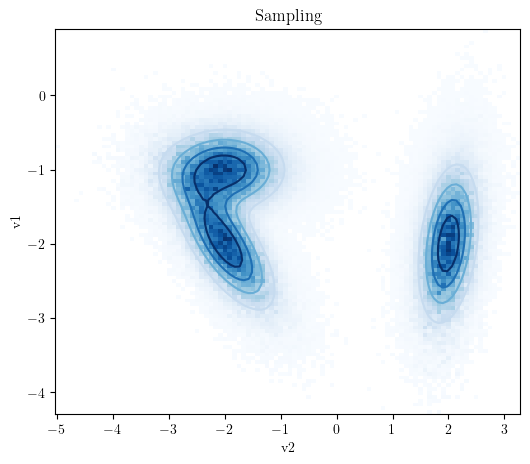

In [4]:
xlist = np.linspace(-4.0, 4.0, 100)
ylist = np.linspace(-4.0, 4, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = Ptarg(np.array([X, Y]))


fig,ax=plt.subplots(1,1,figsize=(6, 5))

h2d = ax.hist2d(yVec[0],yVec[1],cmin=1,bins=100,label='histo algo',cmap=plt.cm.Blues,facecolor='w')
ax.contour(X, Y, Z/np.nanmax(Z),4,alpha=1,cmap='Blues',extend='max')
ax.set_title('Sampling')
ax.set_xlabel('v2')
ax.set_ylabel('v1')
plt.show()

### 3.2 Figure 3 (b) <a name="Fig1B"></a>

In [5]:
xVecA = np.load('data/2D_AlgoA_NMC=2e+06_dxMax=2_n=4_xVec.npy')
xVecB = np.load('data/2D_AlgoB_NMC=2e+06_dxMax=2_n=4_xVec.npy')
yVec4 = np.load('data/2D_AlgoA_NMC=2e+06_dxMax=2_n=4_yVec.npy')
yVec10 = np.load('data/2D_AlgoA_NMC=1e+06_dxMax=2_n=10_yVec.npy')

In [6]:
# prior and target distributions - v2 projection
dx=0.01
dy=0.01
x=-4
xVecTx=np.array([])
yVecTx=np.array([])
yVec0x=np.array([])
nm=0.
nm0=0.
while(x<4):
    y=-4
    py=0
    py0=0
    while(y<2):
        py+=Ptarg([x,y])
        py0+=prior_prob([x,y])
        y+=dy
    nm=nm+dx*py
    nm0=nm0+dx*py0
    xVecTx=np.append(xVecTx,x)
    yVecTx=np.append(yVecTx,py)
    yVec0x=np.append(yVec0x,py0)
    x=x+dx
yVecTx=yVecTx/nm
yVec0x=yVec0x/nm0

In [7]:
# prior and target distributions - v1 projection
dx=0.01
dy=0.01
y=-4
xVecTy=np.array([])
yVecTy=np.array([])
yVec0y=np.array([])
nm=0.
nm0=0.
while(y<2):
    py=0
    x=-4
    py0=0
    while(x<4):
        py+=Ptarg([x,y]) 
        py0+=prior_prob([x,y])
        x+=dx
    nm=nm+dy*py
    nm0=nm0+dx*py0
    xVecTy=np.append(xVecTy,y)
    yVecTy=np.append(yVecTy,py)
    yVec0y=np.append(yVec0y,py0)
    y=y+dy
yVecTy=yVecTy/nm
yVec0y=yVec0y/nm0

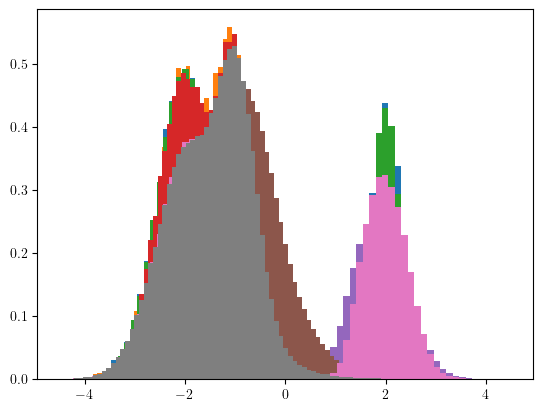

In [8]:
# Projections of the samplings in the v1 and v2 directions

xVecAdistx, binsx, patches = pyplot.hist(xVecA[0],bins=70, density=True,range=(-4.5,4.5))
xVecAdisty, binsy, patches = pyplot.hist(xVecA[1],bins=70, density=True,range=(-4.5,2))
xVecBdistx, binsx, patches = pyplot.hist(xVecB[0],bins=70, density=True,range=(-4.5,4.5))
xVecBdisty, binsy, patches = pyplot.hist(xVecB[1],bins=70, density=True,range=(-4.5,2))
yVec4distx, binsxnew, patches = pyplot.hist(yVec4[0],bins=70, density=True,range=(-4.5,4.5))
yVec4disty, binsynew, patches = pyplot.hist(yVec4[1],bins=70, density=True,range=(-4.5,2))
yVec10distx, binsxnew, patches = pyplot.hist(yVec10[0],bins=70, density=True,range=(-4.5,4.5))
yVec10disty, binsynew, patches = pyplot.hist(yVec10[1],bins=70, density=True,range=(-4.5,2))

newbinsx= binsx - (binsx[1]-binsx[0])/2
newbinsx=newbinsx[1:]

newbinsy= binsy - (binsy[1]-binsy[0])/2
newbinsy=newbinsy[1:]

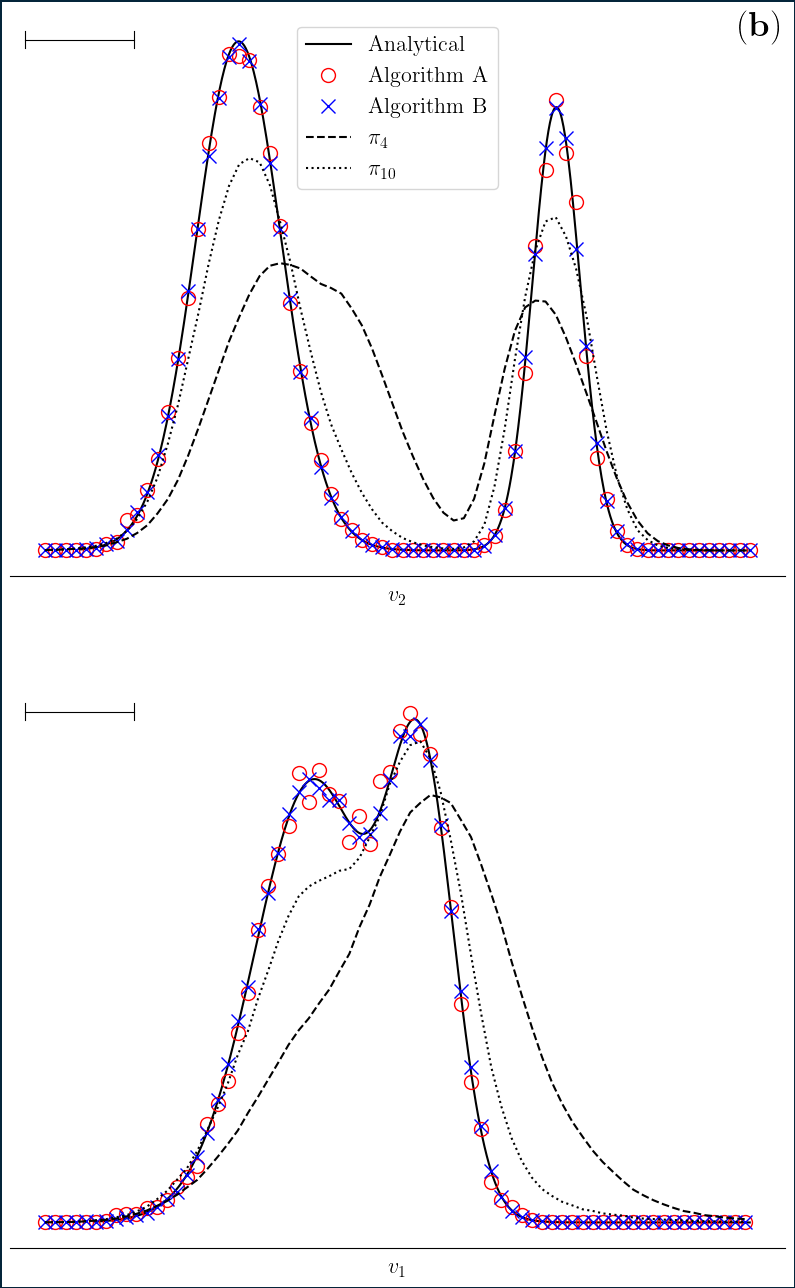

In [9]:
# Figure 3(b)
fig, axs = plt.subplots(2,figsize=(10, 16),linewidth=2, edgecolor="#04253a")

axs[0].plot(xVecTx,yVecTx,color='k',label=r'Analytical')
axs[0].plot(newbinsx,xVecAdistx,'o',color='r',fillstyle='none',markersize=10,label=r'Algorithm A')
axs[0].plot(newbinsx,xVecBdistx,'x',color='b',markersize=10,label=r'Algorithm B')
axs[0].plot(newbinsx,yVec4distx,'--',color='k',label=r'$\pi_4$')
axs[0].plot(newbinsx,yVec10distx,':',color='k',label=r'$\pi_{10}$')
axs[0].legend(fontsize=16,loc ='upper center')
axs[0].set_xlabel(r'$v_2$',fontsize=16)
ob2 = AnchoredHScaleBar(size=1, label="1 unit", loc=2, frameon=False,pad=0.6,sep=4, linekw=dict(color="k", linewidth=0.8)) 

axs[0].add_artist(ob2)
axs[0].text(4.3, 0.5, r'$(\mathrm{\bf b})$', fontsize=25)

axs[1].plot(xVecTy,yVecTy,color='k',label=r'Analytical')
axs[1].plot(newbinsy,xVecAdisty,'o',color='r',fillstyle='none',markersize=10,label=r'Algorithm A')
axs[1].plot(newbinsy,xVecBdisty,'x',color='b',markersize=10,label=r'Algorithm B')
axs[1].plot(newbinsy,yVec4disty,'--',color='k',label=r'$\pi_4$')
axs[1].plot(newbinsy,yVec10disty,':',color='k',label=r'$\pi_{10}$')
axs[1].set_xlabel(r'$v_1$',fontsize=16)

ob2 = AnchoredHScaleBar(size=1, label="1 unit", loc=2, frameon=False,pad=0.6,sep=4, linekw=dict(color="k", linewidth=0.8)) 

axs[1].add_artist(ob2)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)

plt.show()

### 3.3 Figure 5 <a name="Fig3"></a>

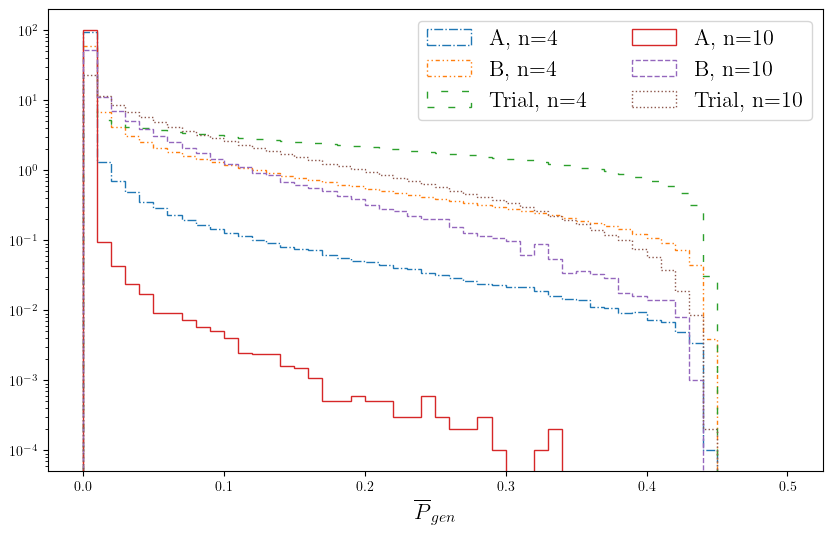

In [11]:
# For Fig. 3
alphaA_zstatsn4 = np.load('data/2D_AlgoA_NMC=2e+06_dxMax=2_n=4_zstats.npy')
alphaB_zstatsn4 = np.load('data/2D_AlgoB_NMC=2e+06_dxMax=2_n=4_zstats.npy')
alphaA_zstatsn10 = np.load('data/2D_AlgoA_NMC=1e+06_dxMax=2_n=10_zstats.npy')
alphaB_zstatsn10 = np.load('data/2D_AlgoB_NMC=100000_dxMax=2_n=10_zstats.npy')



proboldVecAn4 = alphaA_zstatsn4[0]
probnewVecAn4 = alphaA_zstatsn4[1]
PtargoldVecAn4 = alphaA_zstatsn4[2]
PtargnewVecAn4 = alphaA_zstatsn4[3]

zAn4 = PtargnewVecAn4/PtargnewVecAn4 * proboldVecAn4 / probnewVecAn4

proboldVecBn4 = alphaB_zstatsn4[0]
probnewVecBn4 = alphaB_zstatsn4[1]
PtargoldVecAn4  = alphaB_zstatsn4[2]
PtargnewVecBn4 = alphaB_zstatsn4[3]
PgennewVecBn4 = alphaB_zstatsn4[4]

zBn4 = PtargnewVecBn4/PtargnewVecBn4 * proboldVecBn4 / probnewVecBn4

proboldVecAn10 = alphaA_zstatsn10[0]
probnewVecAn10 = alphaA_zstatsn10[1]
PtargoldVecAn10 = alphaA_zstatsn10[2]
PtargnewVecAn10 = alphaA_zstatsn10[3]

zAn10 = PtargnewVecAn10/PtargnewVecAn10 * proboldVecAn10 / probnewVecAn10

proboldVecBn10 = alphaB_zstatsn10[0]
probnewVecBn10 = alphaB_zstatsn10[1]
PtargoldVecAn10  = alphaB_zstatsn10[2]
PtargnewVecBn10 = alphaB_zstatsn10[3]
PgennewVecBn10 = alphaB_zstatsn10[4]

zBn10 = PtargnewVecBn10/PtargnewVecBn10 * proboldVecBn10 / probnewVecBn10

for i in range(len(zAn4)):
    if zAn4[i]>1:
        zAn4[i]=1

for i in range(len(zBn4)):
    if zBn4[i]>1:
        zBn4[i]=1

for i in range(len(zAn10)):
    if zAn10[i]>1:
        zAn10[i]=1

for i in range(len(zBn10)):
    if zBn10[i]>1:
        zBn10[i]=1

fig = plt.figure(figsize=(10, 6))
proboldVecAn4dist, bins, patches = pyplot.hist(proboldVecAn4,bins=50,density=True,label=r'A, n=4',histtype='step',linestyle=('dashdot'),range=(0,0.5))
PgennewVecBn4dist, bins, patches = pyplot.hist(PgennewVecBn4,bins=50,density=True,label=r'B, n=4',histtype='step',linestyle=((0, (3, 2, 1, 2, 1,2))),range=(0,0.5))
probnewVecAn4dist, bins, patches = pyplot.hist(probnewVecAn4,bins=50,density=True,label=r'Trial, n=4',histtype='step',linestyle=((0, (5, 10))),range=(0,0.5))

proboldVecAn10dist, bins, patches = pyplot.hist(proboldVecAn10,bins=50,density=True,label=r'A, n=10',histtype='step',linestyle=('solid'),range=(0,0.5))
PgennewVecBn10dist, bins, patches = pyplot.hist(PgennewVecBn10,bins=50,density=True,label=r'B, n=10',histtype='step',linestyle=('dashed'),range=(0,0.5))
probnewVecAn10dist, bins, patches = pyplot.hist(probnewVecAn10,bins=50,density=True,label=r'Trial, n=10',histtype='step',linestyle=('dotted'),range=(0,0.5))


plt.yscale('log')
plt.xlabel(r'$\overline{P}_{gen}$',fontsize=16)
plt.legend(fontsize=16,ncol=2)

newbins= bins- (bins[1]-bins[0])/2
newbins=newbins[1:]

plt.show()       

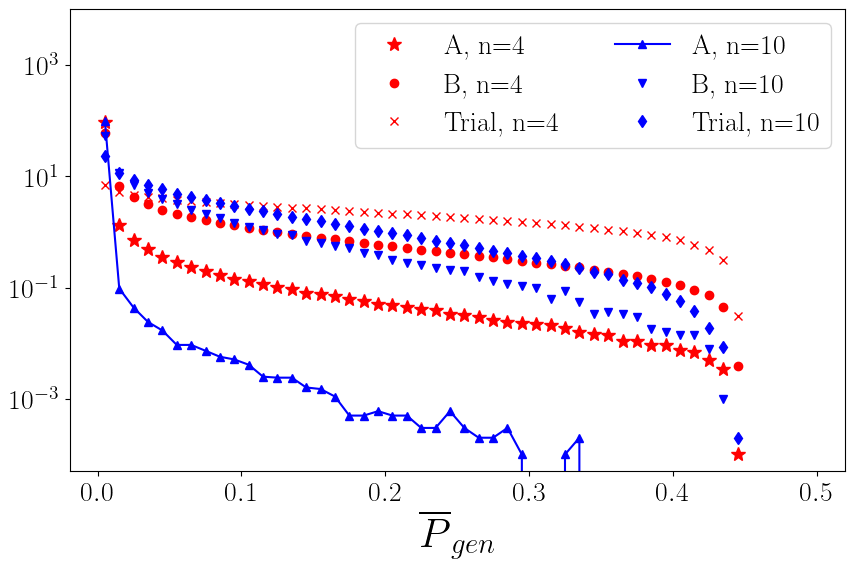

In [12]:
#Fig. 5
fig = plt.figure(figsize=(10, 6))
plt.plot(newbins,proboldVecAn4dist,label=r'A, n=4', marker = '*',color='r',markersize=10,linestyle = 'None')
plt.plot(newbins,PgennewVecBn4dist,label=r'B, n=4',marker = "o",color='r',linestyle = 'None')
plt.plot(newbins,probnewVecAn4dist,label=r'Trial, n=4',marker = "x",color='r',linestyle = 'None')

plt.plot(newbins,proboldVecAn10dist,label=r'A, n=10',marker = "^",color='b')
plt.plot(newbins,PgennewVecBn10dist,label=r'B, n=10',marker = "v",color='b',linestyle = 'None')
plt.plot(newbins,probnewVecAn10dist,label=r'Trial, n=10',marker = "d",color='b',linestyle = 'None')

plt.ylim(0.00005,10000)
plt.yscale('log')
plt.xlabel(r'$\overline{P}_{gen}$',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(fontsize=20,ncol=2, loc=1)

plt.show()


### 3.4 Figure 9 <a name="Fig.9"></a>

In [13]:
xVecA = np.load('data/2D_AlgoA_AS-1_3_NMC=4e+06_dxMax=2_n=4_xVec.npy')
xVecB = np.load('data/2D_AlgoB_AS-1_3_NMC=2e+06_dxMax=2_n=4_xVec.npy')
yVec4 = np.load('data/2D_AlgoA_AS-1_3_NMC=2e+06_dxMax=2_n=4_yVec.npy')
yVec10 = np.load('data/2D_AlgoA_AS-1_3_NMC=2e+06_dxMax=2_n=10_yVec.npy')

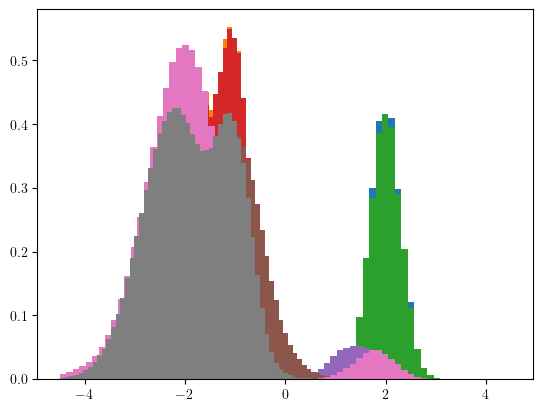

In [14]:
# Projections of the samplings in the v1 and v2 directions

xVecAdistx, binsx, patches = pyplot.hist(xVecA[0],bins=70, density=True,range=(-4.5,4.5))
xVecAdisty, binsy, patches = pyplot.hist(xVecA[1],bins=70, density=True,range=(-4.5,2))
xVecBdistx, binsx, patches = pyplot.hist(xVecB[0],bins=70, density=True,range=(-4.5,4.5))
xVecBdisty, binsy, patches = pyplot.hist(xVecB[1],bins=70, density=True,range=(-4.5,2))
yVec4distx, binsxnew, patches = pyplot.hist(yVec4[0],bins=70, density=True,range=(-4.5,4.5))
yVec4disty, binsynew, patches = pyplot.hist(yVec4[1],bins=70, density=True,range=(-4.5,2))
yVec10distx, binsxnew, patches = pyplot.hist(yVec10[0],bins=70, density=True,range=(-4.5,4.5))
yVec10disty, binsynew, patches = pyplot.hist(yVec10[1],bins=70, density=True,range=(-4.5,2))

newbinsx= binsx - (binsx[1]-binsx[0])/2
newbinsx=newbinsx[1:]

newbinsy= binsy - (binsy[1]-binsy[0])/2
newbinsy=newbinsy[1:]

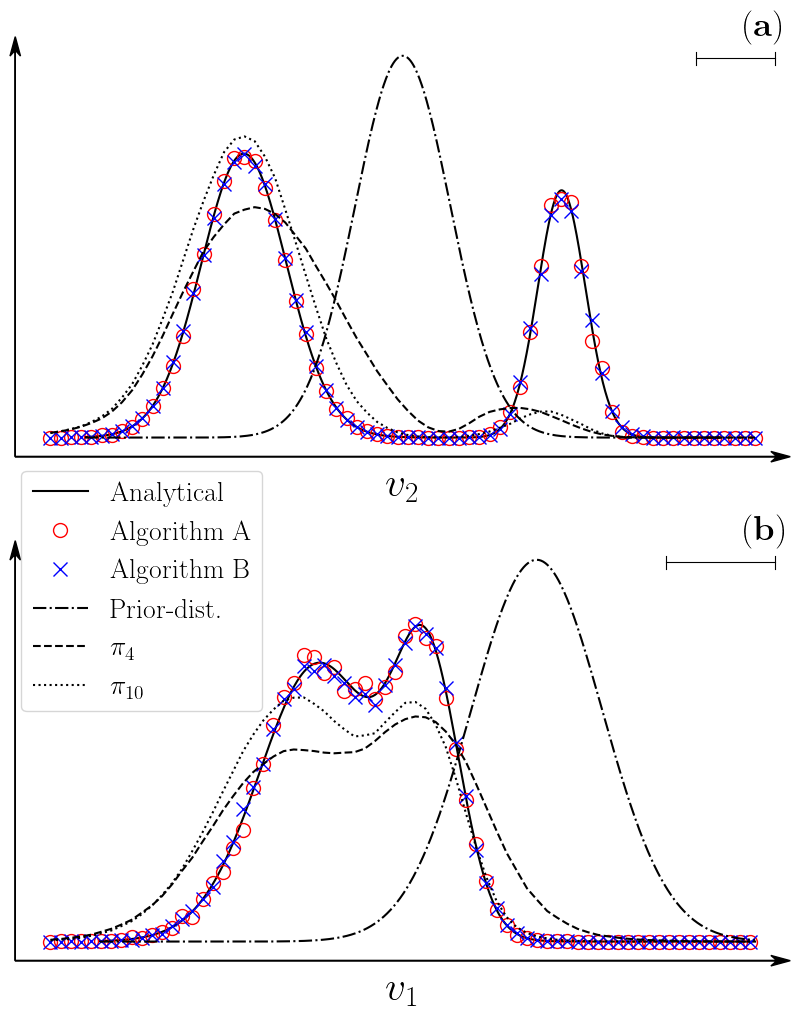

In [15]:
fig, axs = plt.subplots(2,figsize=(10, 12))

axs[0].plot(xVecTx,yVecTx,color='k',label=r'Analytical')
axs[0].plot(newbinsx,xVecAdistx,'o',color='r',fillstyle='none',markersize=10,label=r'Algorithm A')
axs[0].plot(newbinsx,xVecBdistx,'x',color='b',markersize=10,label=r'Algorithm B')
axs[0].plot(newbinsx,yVec4distx,'--',color='k',label=r'$\pi^4$')
axs[0].plot(newbinsx,yVec10distx,':',color='k',label=r'$\pi^{10}$')
axs[0].plot(xVecTx,yVec0x,'-.',color='k',label=r'Prior-distribution')
axs[0].set_xlabel(r'$v_2$',fontsize=30)

ob2 = AnchoredHScaleBar(ax=axs[0],size=1, label="1 unit", loc=1, frameon=False,pad=0.6,sep=4, linekw=dict(color="k", linewidth=0.8)) 

axs[0].add_artist(ob2)
axs[0].text(4.3, 0.7, r'$(\mathrm{\bf a})$', fontsize=25)

xmin, xmax = axs[0].get_xlim()
ymin, ymax = axs[0].get_ylim()
axs[0].set_xlim(xmin,xmax)
axs[0].set_ylim(ymin,ymax)

# get width and height of axes object to compute
# matching arrowhead length and width
dps = fig.dpi_scale_trans.inverted()
bbox = axs[0].get_window_extent().transformed(dps)
width, height = bbox.width, bbox.height

# manual arrowhead width and length
hw = 1./40.*(ymax-ymin)
hl = 1./40.*(xmax-xmin)
lw = 1. # axis line width
ohg = 0.3 # arrow overhang

# compute matching arrowhead length and width
yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width
yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

# draw x and y axis
axs[0].arrow(xmin, ymin, xmax-xmin, 0, fc='k', ec='k', lw = lw,
         head_width=hw, head_length=hl, overhang = ohg,
         length_includes_head= True, clip_on = False)

axs[0].arrow(xmin, ymin, 0, ymax-ymin, fc='k', ec='k', lw = lw,
         head_width=yhw, head_length=yhl, overhang = ohg,
         length_includes_head= True, clip_on = False)


axs[1].plot(xVecTy,yVecTy,color='k',label=r'Analytical')
axs[1].plot(newbinsy,xVecAdisty,'o',color='r',fillstyle='none',markersize=10,label=r'Algorithm A')
axs[1].plot(newbinsy,xVecBdisty,'x',color='b',markersize=10,label=r'Algorithm B')
axs[1].plot(xVecTy,yVec0y,'-.',color='k',label=r'Prior-dist.')
axs[1].plot(newbinsy,yVec4disty,'--',color='k',label=r'$\pi_4$')
axs[1].plot(newbinsy,yVec10disty,':',color='k',label=r'$\pi_{10}$')
axs[1].set_xlabel(r'$v_1$',fontsize=30)
axs[1].text(1.9, 0.7, r'$(\mathrm{\bf b})$', fontsize=25)
axs[1].legend(fontsize=20,ncol=1,loc =2,bbox_to_anchor=(-0.01,1.2))

xmin, xmax = axs[1].get_xlim()
ymin, ymax = axs[1].get_ylim()

axs[1].set_xlim(xmin,xmax)
axs[1].set_ylim(ymin,ymax)

# get width and height of axes object to compute
# matching arrowhead length and width
dps = fig.dpi_scale_trans.inverted()
bbox = axs[1].get_window_extent().transformed(dps)
width, height = bbox.width, bbox.height

# manual arrowhead width and length
hw = 1./40.*(ymax-ymin)
hl = 1./40.*(xmax-xmin)
lw = 1. # axis line width
ohg = 0.3 # arrow overhang

# compute matching arrowhead length and width
yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width
yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

# draw x and y axis
axs[1].arrow(xmin, ymin, xmax-xmin, 0, fc='k', ec='k', lw = lw,
         head_width=hw, head_length=hl, overhang = ohg,
         length_includes_head= True, clip_on = False)

axs[1].arrow(xmin, ymin, 0, ymax-ymin, fc='k', ec='k', lw = lw,
         head_width=yhw, head_length=yhl, overhang = ohg,
         length_includes_head= True, clip_on = False)

ob3 = AnchoredHScaleBar(ax=axs[1],size=1, label="1 unit", loc=1, frameon=False,pad=0.6,sep=4, linekw=dict(color="k", linewidth=0.8)) 

axs[1].add_artist(ob3)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)


plt.show()


### 3.5 Figure 10 <a name="Fig.SI1"></a>

In [16]:
xVecA = np.load('data/2D_AlgoAPrime_NMC=2e+06_dxMax=2_n=4_xVec.npy')
xVecB = np.load('data/2D_AlgoBPrime_NMC=2e+06_dxMax=2_n=4_xVec.npy')
yVec4 = np.load('data/2D_AlgoAPrime_NMC=2e+06_dxMax=2_n=4_yVec.npy')
yVec10 = np.load('data/2D_AlgoAPrime_NMC=1e+06_dxMax=2_n=10_yVec.npy')

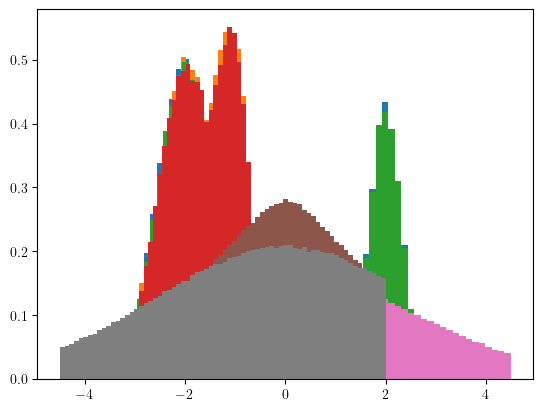

In [17]:
xVecAdistx, binsx, patches = pyplot.hist(xVecA[0],bins=70, density=True,range=(-4.5,4.5))
xVecAdisty, binsy, patches = pyplot.hist(xVecA[1],bins=70, density=True,range=(-4.5,2))
xVecBdistx, binsx, patches = pyplot.hist(xVecB[0],bins=70, density=True,range=(-4.5,4.5))
xVecBdisty, binsy, patches = pyplot.hist(xVecB[1],bins=70, density=True,range=(-4.5,2))
yVec4distx, binsxnew, patches = pyplot.hist(yVec4[0],bins=70, density=True,range=(-4.5,4.5))
yVec4disty, binsynew, patches = pyplot.hist(yVec4[1],bins=70, density=True,range=(-4.5,2))
yVec10distx, binsxnew, patches = pyplot.hist(yVec10[0],bins=70, density=True,range=(-4.5,4.5))
yVec10disty, binsynew, patches = pyplot.hist(yVec10[1],bins=70, density=True,range=(-4.5,2))

newbinsx= binsx - (binsx[1]-binsx[0])/2
newbinsx=newbinsx[1:]

newbinsy= binsy - (binsy[1]-binsy[0])/2
newbinsy=newbinsy[1:]

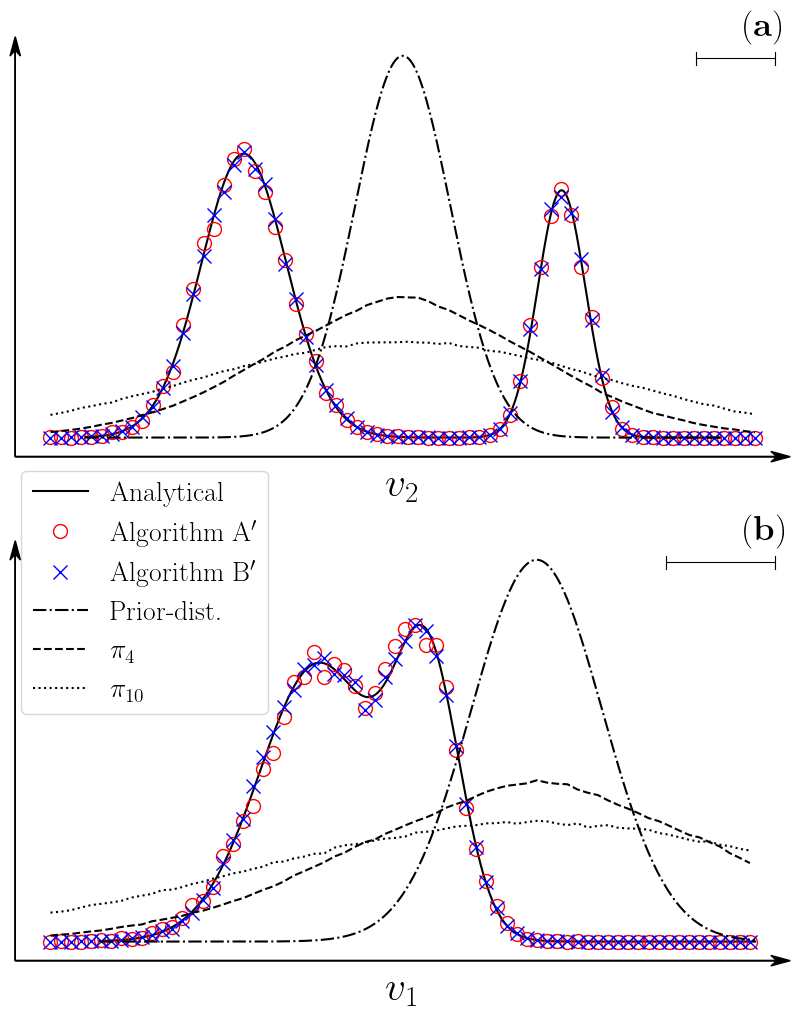

In [18]:
#Fig.10
fig, axs = plt.subplots(2,figsize=(10, 12))

axs[0].plot(xVecTx,yVecTx,color='k',label=r'Analytical')
axs[0].plot(newbinsx,xVecAdistx,'o',color='r',fillstyle='none',markersize=10,label=r'Algorithm A')
axs[0].plot(newbinsx,xVecBdistx,'x',color='b',markersize=10,label=r'Algorithm B')
axs[0].plot(newbinsx,yVec4distx,'--',color='k',label=r'$\pi^4$')
axs[0].plot(newbinsx,yVec10distx,':',color='k',label=r'$\pi^{10}$')
axs[0].plot(xVecTx,yVec0x,'-.',color='k',label=r'Prior-distribution')
axs[0].set_xlabel(r'$v_2$',fontsize=30)

ob2 = AnchoredHScaleBar(ax=axs[0],size=1, label="1 unit", loc=1, frameon=False,pad=0.6,sep=4, linekw=dict(color="k", linewidth=0.8)) 

axs[0].add_artist(ob2)
axs[0].text(4.3, 0.7, r'$(\mathrm{\bf a})$', fontsize=25)

xmin, xmax = axs[0].get_xlim()
ymin, ymax = axs[0].get_ylim()
axs[0].set_xlim(xmin,xmax)
axs[0].set_ylim(ymin,ymax)

# get width and height of axes object to compute
# matching arrowhead length and width
dps = fig.dpi_scale_trans.inverted()
bbox = axs[0].get_window_extent().transformed(dps)
width, height = bbox.width, bbox.height

# manual arrowhead width and length
hw = 1./40.*(ymax-ymin)
hl = 1./40.*(xmax-xmin)
lw = 1. # axis line width
ohg = 0.3 # arrow overhang

# compute matching arrowhead length and width
yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width
yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

# draw x and y axis
axs[0].arrow(xmin, ymin, xmax-xmin, 0, fc='k', ec='k', lw = lw,
         head_width=hw, head_length=hl, overhang = ohg,
         length_includes_head= True, clip_on = False)

axs[0].arrow(xmin, ymin, 0, ymax-ymin, fc='k', ec='k', lw = lw,
         head_width=yhw, head_length=yhl, overhang = ohg,
         length_includes_head= True, clip_on = False)


axs[1].plot(xVecTy,yVecTy,color='k',label=r'Analytical')
axs[1].plot(newbinsy,xVecAdisty,'o',color='r',fillstyle='none',markersize=10,label=r'Algorithm A$^\prime$')
axs[1].plot(newbinsy,xVecBdisty,'x',color='b',markersize=10,label=r'Algorithm B$^\prime$')
axs[1].plot(xVecTy,yVec0y,'-.',color='k',label=r'Prior-dist.')
axs[1].plot(newbinsy,yVec4disty,'--',color='k',label=r'$\pi_4$')
axs[1].plot(newbinsy,yVec10disty,':',color='k',label=r'$\pi_{10}$')
axs[1].set_xlabel(r'$v_1$',fontsize=30)
axs[1].text(1.9, 0.7, r'$(\mathrm{\bf b})$', fontsize=25)
axs[1].legend(fontsize=20,ncol=1,loc =2,bbox_to_anchor=(-0.01,1.2))

xmin, xmax = axs[1].get_xlim()
ymin, ymax = axs[1].get_ylim()

axs[1].set_xlim(xmin,xmax)
axs[1].set_ylim(ymin,ymax)

# get width and height of axes object to compute
# matching arrowhead length and width
dps = fig.dpi_scale_trans.inverted()
bbox = axs[1].get_window_extent().transformed(dps)
width, height = bbox.width, bbox.height

# manual arrowhead width and length
hw = 1./40.*(ymax-ymin)
hl = 1./40.*(xmax-xmin)
lw = 1. # axis line width
ohg = 0.3 # arrow overhang

# compute matching arrowhead length and width
yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width
yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

# draw x and y axis
axs[1].arrow(xmin, ymin, xmax-xmin, 0, fc='k', ec='k', lw = lw,
         head_width=hw, head_length=hl, overhang = ohg,
         length_includes_head= True, clip_on = False)

axs[1].arrow(xmin, ymin, 0, ymax-ymin, fc='k', ec='k', lw = lw,
         head_width=yhw, head_length=yhl, overhang = ohg,
         length_includes_head= True, clip_on = False)

ob3 = AnchoredHScaleBar(ax=axs[1],size=1, label="1 unit", loc=1, frameon=False,pad=0.6,sep=4, linekw=dict(color="k", linewidth=0.8)) 

axs[1].add_artist(ob3)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)


plt.show()


## 4. Asymptotic distribution <a name="Asymptotic"></a>

### 4.1 Generating the Asymptotic distribution <a name="GenAsymptotic"></a>

Number of iterations:  0 Acceptance rate: 0.0
Number of iterations:  20000 Acceptance rate: 0.07054647267636618
Number of iterations:  40000 Acceptance rate: 0.07154821129471763
Number of iterations:  60000 Acceptance rate: 0.07053215779737004
Number of iterations:  80000 Acceptance rate: 0.0711116111048612


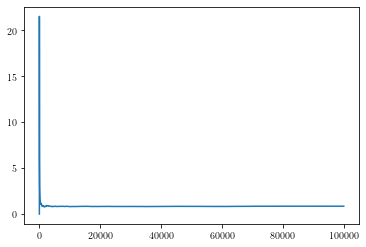

Number of iterations:  100000 Acceptance rate: 0.07113928860711392
Number of iterations:  120000 Acceptance rate: 0.07159107007441605
Number of iterations:  140000 Acceptance rate: 0.07199234291183634
Number of iterations:  160000 Acceptance rate: 0.07221204867469579
Number of iterations:  180000 Acceptance rate: 0.07195515580468997


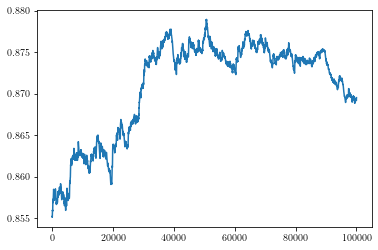

Number of iterations:  200000 Acceptance rate: 0.0722196389018055
Number of iterations:  220000 Acceptance rate: 0.07234512570397407
Number of iterations:  240000 Acceptance rate: 0.07224553231028204
Number of iterations:  260000 Acceptance rate: 0.07219972230876034
Number of iterations:  280000 Acceptance rate: 0.07233188452898383


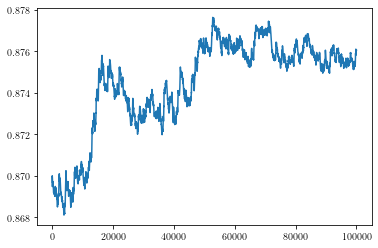

Number of iterations:  300000 Acceptance rate: 0.07240642531191563
Number of iterations:  320000 Acceptance rate: 0.07240914872141024
Number of iterations:  340000 Acceptance rate: 0.07248508092623257
Number of iterations:  360000 Acceptance rate: 0.07229146585703929
Number of iterations:  380000 Acceptance rate: 0.07247612506282879


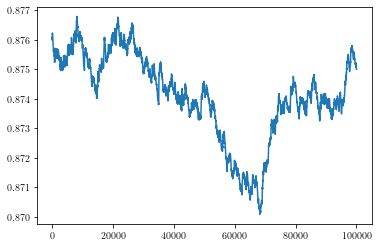

Number of iterations:  400000 Acceptance rate: 0.07250481873795316
Number of iterations:  420000 Acceptance rate: 0.0722831612305685
Number of iterations:  440000 Acceptance rate: 0.07232938106958847
Number of iterations:  460000 Acceptance rate: 0.0724954945750118
Number of iterations:  480000 Acceptance rate: 0.0723352659681959


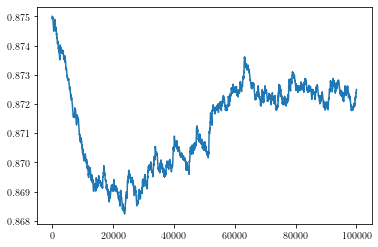

Number of iterations:  500000 Acceptance rate: 0.07231785536428927
Number of iterations:  520000 Acceptance rate: 0.07221332266668717
Number of iterations:  540000 Acceptance rate: 0.07222949587130394
Number of iterations:  560000 Acceptance rate: 0.0723480850927052
Number of iterations:  580000 Acceptance rate: 0.07224987543124925


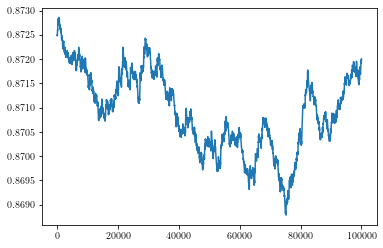

Number of iterations:  600000 Acceptance rate: 0.07232321279464535
Number of iterations:  620000 Acceptance rate: 0.07234665750539113
Number of iterations:  640000 Acceptance rate: 0.07239676188005956
Number of iterations:  660000 Acceptance rate: 0.0723589812742708
Number of iterations:  680000 Acceptance rate: 0.07237783473847832


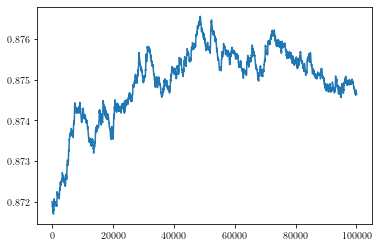

Number of iterations:  700000 Acceptance rate: 0.07238561087769875
Number of iterations:  720000 Acceptance rate: 0.07228601071387401
Number of iterations:  740000 Acceptance rate: 0.07224314561737079
Number of iterations:  760000 Acceptance rate: 0.07219332606141307
Number of iterations:  780000 Acceptance rate: 0.07209349731602908


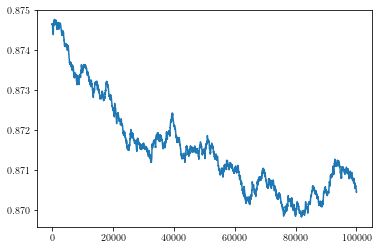

Number of iterations:  800000 Acceptance rate: 0.07207740990323762
Number of iterations:  820000 Acceptance rate: 0.07201088779160025
Number of iterations:  840000 Acceptance rate: 0.07201658093264175
Number of iterations:  860000 Acceptance rate: 0.07210107895223378
Number of iterations:  880000 Acceptance rate: 0.072128327126901


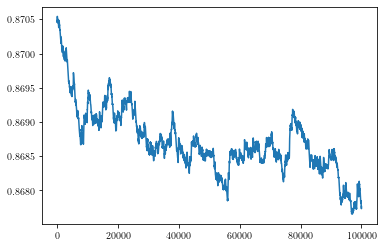

Number of iterations:  900000 Acceptance rate: 0.07201880886799014
Number of iterations:  920000 Acceptance rate: 0.0720477477741872
Number of iterations:  940000 Acceptance rate: 0.07205524249442288
Number of iterations:  960000 Acceptance rate: 0.07200617499356772
Number of iterations:  980000 Acceptance rate: 0.07201319182327365


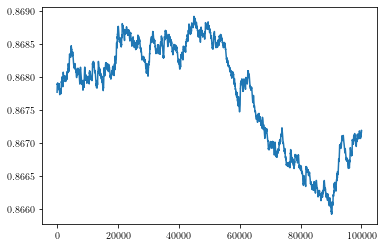

Final acceptance rate: 0.071934


In [138]:
ndim = 2


NMC=1000000
iMC=0
StartSampling=600000 #First iteration with the angles recorded
accrate=0
dxMax=4#/np.sqrt(n)


xVecE = np.arange(np.int(NMC/10)+1)

MeanEnergyVec = np.array([0])
xVecAS=np.zeros((ndim,NMC-StartSampling-1))

    
# Generate the sample configuration and compute the prior probability
x=sample_prior()
Pold=Ptarg(x)


iMC=0

while(iMC<NMC):
    dxVec=dxMax*(2*np.random.rand(ndim)-1.)

    y=np.zeros((ndim,1))
    for i in range(ndim):
        y[i]=x[i]+dxVec[i]
    Pnew = Ptarg(y)


# Metropolis
    accxy=Pnew/Pold

    # Implement Heat Bath
#    accxy=Pnew/(Pnew+Pold)

#    accxx=1.-accxy
        
    rnd=np.random.rand(1)
    if(rnd[0]<accxy):
        x=deepcopy(y)
        Pold = Pnew
        accrate=accrate+1
        
    MeanEnergyVec = np.append(MeanEnergyVec, (MeanEnergyVec[-1]*iMC - np.log(Ptarg(x)))  / (iMC+1) )

    
    
    if iMC > StartSampling:
        for i in range(ndim):
            xVecAS[i,iMC-StartSampling-1]=x[i]

            
    if(np.mod(iMC*50,NMC)==0):
        print('Number of iterations: ',iMC, 'Acceptance rate:',accrate/(iMC+1))
        
    iMC=iMC+1
    
    if(np.mod(iMC*10,NMC)==0):
        pyplot.plot(xVecE,MeanEnergyVec)
        plt.show()
        MeanEnergyVec = np.array([MeanEnergyVec[-1]])
    
        
print('Final acceptance rate:',accrate/(NMC))

### 4.2 Sampling of the Asymptotic Distribution <a name="SampAsymptotic"></a>

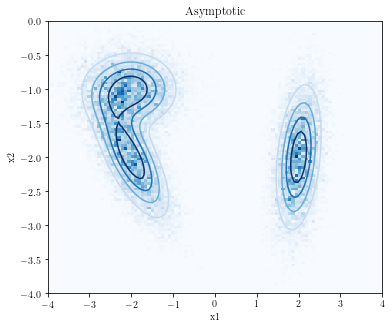

In [26]:
# Sampling the asymptotic distirbution
xlist = np.linspace(-4.0, 4.0, 100)
ylist = np.linspace(-4.0, 0, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = Ptarg(np.array([X, Y]))




fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))


ax1.hist2d(xVecAS[0],xVecAS[1],bins=100,density=True,label='histo algo',range= [[-4, 4], [-4, 0]],cmap=plt.cm.Blues)
ax1.contour(X, Y, Z/np.nanmax(ZT),4,alpha=1,cmap='Blues',extend='max')

#fig.colorbar(cp) # Add a colorbar to a plot
ax1.set_title('Asymptotic')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')

plt.show()

In [64]:
np.save('data/2D_Asymptotic', xVecAS)

### 4.3 Comparison Asymptotic Vs TMCMC <a name="CompASTMCMC"></a>

In [26]:
xVecAS= np.load('data/2D_Asymptotic.npy')

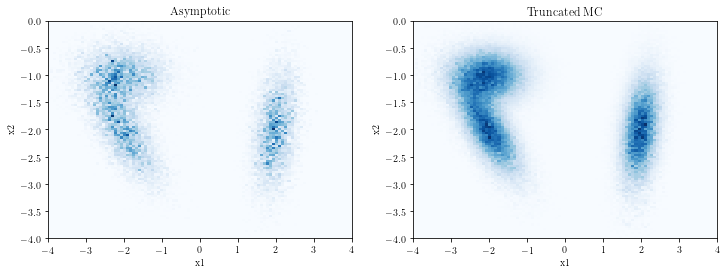

In [22]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

h2dAS = ax1.hist2d(xVecAS[0],xVecAS[1],bins=100,density=True,label='histo algo',range= [[-4, 4], [-4, 0]],cmap=plt.cm.Blues)
h2d = ax2.hist2d(xVec[0],xVec[1],bins=100,density=True,label='histo algo',range= [[-4, 4], [-4,0]],cmap=plt.cm.Blues)
#fig.colorbar(cp) # Add a colorbar to a plot
ax1.set_title('Asymptotic')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')

ax2.set_title('Truncated MC')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
plt.show()

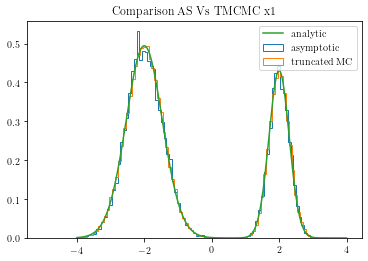

In [23]:
# target distribution 
dx=0.01
dy=0.01
x=-4
xVecT=np.array([])
yVecT=np.array([])
nm=0.
while(x<4):
    y=-4
    py=0
    while(y<2):
        py+=Ptarg([x,y])
        y+=dy
    nm=nm+dx*py
    xVecT=np.append(xVecT,x)
    yVecT=np.append(yVecT,py)
    x=x+dx
yVecT=yVecT/nm
    
pyplot.hist(yVecAS[0],bins=100,density=True,label='asymptotic',histtype='step')
pyplot.hist(yVec[0],bins=100,density=True,label='truncated MC',histtype='step')
pyplot.plot(xVecT,yVecT,label='analytic')
pyplot.title('Comparison AS Vs TMCMC x1')
pyplot.legend()
plt.show()





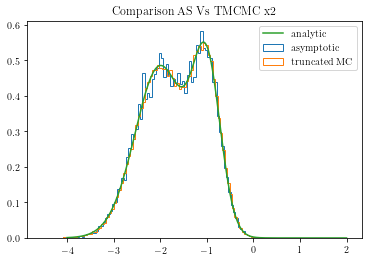

In [24]:
# target distribution 
dx=0.01
dy=0.01
y=-4
xVecT=np.array([])
yVecT=np.array([])
nm=0.
while(y<2):
    py=0
    x=-4
    while(x<4):
        py+=Ptarg([x,y]) 
        x+=dx
    nm=nm+dy*py
    xVecT=np.append(xVecT,y)
    yVecT=np.append(yVecT,py)
    y=y+dy
yVecT=yVecT/nm
    
#pyplot.hist(xVectest[1],bins=100,density=True,label='histo algo')
pyplot.hist(yVecAS[1],bins=100,density=True,label='asymptotic',histtype='step')
pyplot.hist(yVec[1],bins=100,density=True,label='truncated MC',histtype='step')
pyplot.plot(xVecT,yVecT,label='analytic ')
pyplot.title('Comparison AS Vs TMCMC x2')
pyplot.legend()
plt.show()

